In [1]:
import pandas as pd

# Loading the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merging datasets on CustomerID
data = transactions.merge(customers, on='CustomerID')

# Displaying the first few rows of the merged dataset
print(data.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


In [2]:
# Create features for each customer
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',          # Total spending
    'TransactionID': 'count',     # Number of transactions
    'ProductID': lambda x: len(set(x)),  # Unique products purchased
    'Region': 'first',            # Assuming region doesn't change
}).reset_index()

# Rename columns for clarity
customer_features.columns = ['CustomerID', 'TotalSpent', 'TransactionCount', 'UniqueProducts', 'Region']

# One-hot encoding for the Region column
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Display the customer features
print(customer_features.head())


  CustomerID  TotalSpent  TransactionCount  UniqueProducts  Region_Europe  \
0      C0001     3354.52                 5               5          False   
1      C0002     1862.74                 4               4          False   
2      C0003     2725.38                 4               4          False   
3      C0004     5354.88                 8               8          False   
4      C0005     2034.24                 3               3          False   

   Region_North America  Region_South America  
0                 False                  True  
1                 False                 False  
2                 False                  True  
3                 False                  True  
4                 False                 False  


In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the features for better clustering performance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))

# Define the range of clusters to test
cluster_range = range(2, 11)
inertia = []
db_index = []

# Perform K-Means clustering for different cluster sizes and calculate DB Index
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)

    inertia.append(kmeans.inertia_)

    # Calculate Davies-Bouldin Index (DB Index)
    from sklearn.metrics import davies_bouldin_score
    db_index.append(davies_bouldin_score(scaled_features, kmeans.labels_))

# Display inertia and DB Index values for each cluster size
for i, n in enumerate(cluster_range):
    print(f'Clusters: {n}, Inertia: {inertia[i]}, DB Index: {db_index[i]}')


Clusters: 2, Inertia: 837.6979841821683, DB Index: 1.4893831907607504
Clusters: 3, Inertia: 646.7417077455941, DB Index: 1.2486599484440022
Clusters: 4, Inertia: 522.034884706035, DB Index: 1.0619273680549413
Clusters: 5, Inertia: 384.19843405638426, DB Index: 0.9745263844289707
Clusters: 6, Inertia: 327.82599429710854, DB Index: 0.9707936515793532
Clusters: 7, Inertia: 281.34354757570696, DB Index: 0.8612487939350613
Clusters: 8, Inertia: 255.8389198422318, DB Index: 0.8336873045082649
Clusters: 9, Inertia: 234.25716724653145, DB Index: 0.8975073391981714
Clusters: 10, Inertia: 190.09950995141054, DB Index: 0.8452481981343534


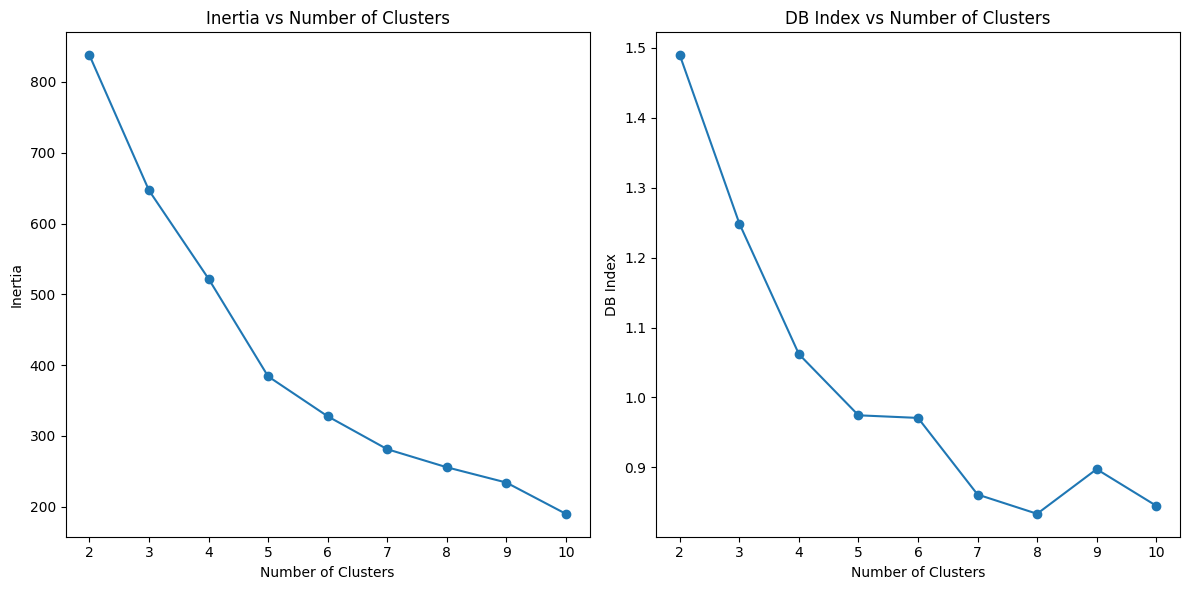

In [4]:
import matplotlib.pyplot as plt

# Plotting Inertia vs Number of Clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plotting DB Index vs Number of Clusters
plt.subplot(1, 2, 2)
plt.plot(cluster_range, db_index, marker='o')
plt.title('DB Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

plt.tight_layout()
plt.show()


In [5]:
# Choosing optimal number of clusters
optimal_clusters = 4

kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans_final.fit_predict(scaled_features)

# Display customers with their assigned clusters
print(customer_features[['CustomerID', 'TotalSpent', 'TransactionCount', 'UniqueProducts', 'Cluster']].head())


  CustomerID  TotalSpent  TransactionCount  UniqueProducts  Cluster
0      C0001     3354.52                 5               5        1
1      C0002     1862.74                 4               4        2
2      C0003     2725.38                 4               4        1
3      C0004     5354.88                 8               8        1
4      C0005     2034.24                 3               3        2


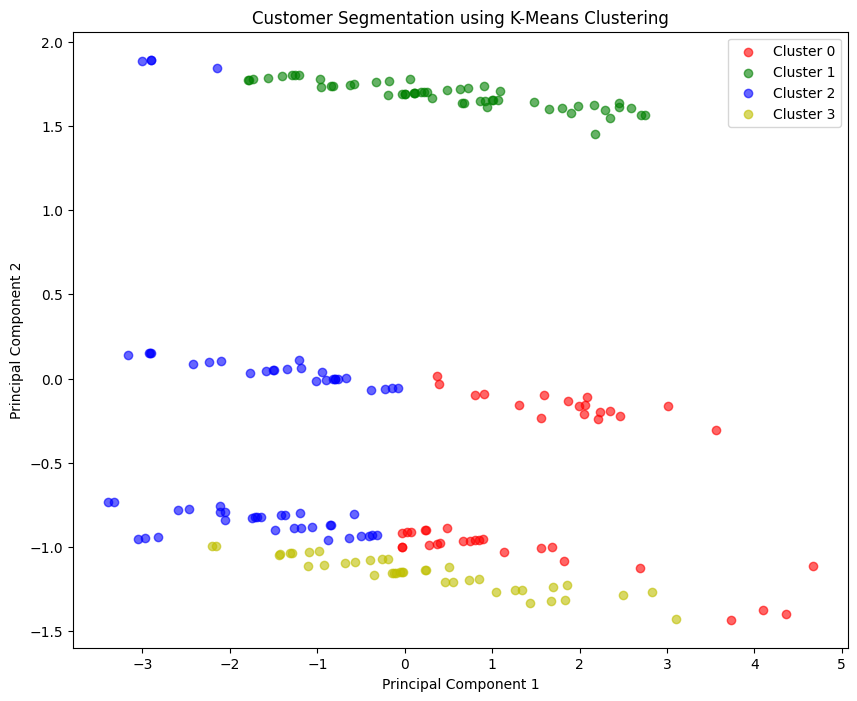

In [6]:
from sklearn.decomposition import PCA

# Reduce dimensions with PCA for visualization purposes
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame for PCA results and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_features['Cluster']

# Plotting the clusters in PCA space
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster in range(optimal_clusters):
    plt.scatter(pca_df[pca_df['Cluster'] == cluster]['PC1'],
                pca_df[pca_df['Cluster'] == cluster]['PC2'],
                label=f'Cluster {cluster}',
                color=colors[cluster % len(colors)],
                alpha=0.6)

plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
